In [1]:
from IPython.display import clear_output, display, HTML
from urllib.parse import urlencode
from datetime import datetime, timedelta
from collections import OrderedDict
import queue
import requests
import threading
import pandas as pd
import itertools
from math import isnan
import pytz
import json
import csv
import matplotlib.pyplot as plt
from matplotlib.finance import candlestick2_ochl, candlestick_ochl
from matplotlib.dates import date2num, DateFormatter
from matplotlib import pyplot as plt, ticker, style
from time import sleep
    
style.use('ggplot')

TOP_ITEMS_COUNT = 10
DATA_TIMEZONE = pytz.timezone("US/Eastern")
CLIENT_TIMEZONE = pytz.timezone('America/Los_Angeles')
periods = [1, 5, 15, 30, 60, "All day"]

def get_now():
    now = datetime.now(tz=CLIENT_TIMEZONE)
    weekday = now.isoweekday()
    if weekday > 5:
        now = (now - timedelta(days=weekday - 5)).replace(hour=15)
    return now

now = get_now()    
now

datetime.datetime(2017, 8, 25, 15, 25, 13, 374491, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>)

In [2]:
def get_symbols():
    with open("n14_symbols.csv", "r") as f:
        symbols = f.read().split()
    return list(set(symbols))
symbols = get_symbols()
len(symbols)

3198

In [3]:
def get_minute_data(symbol, now):
    now = now.replace(second=0, microsecond=0)
    start = now.replace(hour=6, minute=30)
    if start > now:
        raise ValueError("It's too early")
    
    url = "https://query1.finance.yahoo.com/v7/finance/chart/{}?period1={:.0f}&period2={:.0f}"\
          "&interval=1m&indicators=quote&includeTimestamps=true&"\
          "events=div%7Csplit%7Cearn".format(symbol, start.timestamp(), now.timestamp())
            
    page = requests.get(url)
    result = page.json()['chart']['result']
    if not result:
        print(symbol, page.json())
        return
    
    data = result[0]
    quote = data['indicators']['quote'][0]
    if 'timestamp' not in data:
        return
    times = data['timestamp']
    period = data['meta']['currentTradingPeriod']['regular']
    start, end = period['start'], period['end']
    del quote['volume']
    quote['index'] = [datetime.fromtimestamp(t, tz=DATA_TIMEZONE).astimezone(now.tzinfo) for t in times]
           
    return quote

raw_data = get_minute_data('AAPL', now) # SRCE
raw_data

{'close': [159.8699951171875,
  159.75,
  159.7899932861328,
  159.75,
  160.07000732421875,
  160.08999633789062,
  160.01390075683594,
  160.07650756835938,
  159.9530029296875,
  159.88009643554688,
  160.07000732421875,
  160.02999877929688,
  160.14999389648438,
  160.10899353027344,
  160.19000244140625,
  160.16000366210938,
  160.10000610351562,
  160.125,
  160.09010314941406,
  160.13949584960938,
  160.143798828125,
  160.10000610351562,
  160.21200561523438,
  160.24620056152344,
  160.25,
  160.33999633789062,
  160.27000427246094,
  160.08999633789062,
  160.17550659179688,
  160.13499450683594,
  160.3300018310547,
  160.38499450683594,
  160.3798065185547,
  160.3300018310547,
  160.22999572753906,
  160.19000244140625,
  160.30999755859375,
  160.19000244140625,
  160.24000549316406,
  160.25929260253906,
  160.25,
  160.4600067138672,
  160.41000366210938,
  160.36270141601562,
  160.41000366210938,
  160.32000732421875,
  160.3300018310547,
  160.2899932861328,
  160

In [4]:
def get_df_from_raw_data(rd):
    index = rd['index']
    del rd['index']
    df = pd.DataFrame(rd, index=index)
    df['n_low'] = df.low < df.low.shift(1)
    df['bear_velocity'] = df.n_low.rolling(window=10).sum() * 10
    df['n_high'] = df.high > df.high.shift(1)
    df['bull_velocity'] = df.n_high.rolling(window=10).sum() * 10

    df['min_low'] = df.low.rolling(window=len(df), min_periods=1).min()
    df['min_low_open'] = (df.min_low / df.open - 1) * 100
    df['close_min_low'] = (df.close / df.min_low - 1) * 100
    return df

get_df_from_raw_data(raw_data)[:10]

,close,high,low,open,n_low,bear_velocity,n_high,bull_velocity,min_low,min_low_open,close_min_low
2017-08-25 06:30:00-07:00,159.869995,159.889999,159.640106,159.701996,False,NaN,False,NaN,159.640106,-0.038753,0.144004
2017-08-25 06:31:00-07:00,159.750000,159.960007,159.750000,159.960007,False,NaN,True,NaN,159.640106,-0.199988,0.068838
2017-08-25 06:32:00-07:00,159.789993,159.809998,159.750000,159.800003,False,NaN,False,NaN,159.640106,-0.100061,0.093891
2017-08-25 06:33:00-07:00,159.750000,159.789993,159.600006,159.759995,True,NaN,False,NaN,159.600006,-0.100143,0.093981
2017-08-25 06:34:00-07:00,160.070007,160.139999,159.815002,159.820007,False,NaN,True,NaN,159.600006,-0.137656,0.294487
2017-08-25 06:35:00-07:00,160.089996,160.130005,160.034393,160.100006,False,NaN,False,NaN,159.600006,-0.312305,0.307011
2017-08-25 06:36:00-07:00,160.013901,160.104996,160.000000,160.104996,True,NaN,False,NaN,159.600006,-0.315412,0.259332
2017-08-25 06:37:00-07:00,160.076508,160.149994,159.940002,159.970001,True,NaN,True,NaN,159.600006,-0.231290,0.298560
2017-08-25 06:38:00-07:00,159.953003,160.100006,159.953003,160.098999,False,NaN,False,NaN,159.600006,-0.311678,0.221176
2017-08-25 06:39:00-07:00,159.880096,160.009995,159.880096,159.988007,True,40.0,False,30.0,159.600006,-0.242518,0.175495


In [5]:
def load_data(symbols, time):
    
    num_worker_threads = 100
    
    def worker():
        while True:
            symbol = q.get()
            if symbol is None:
                break
            
            # GET DATA
            data = get_minute_data(symbol, time)
            if data is not None:
                r.put((symbol, data))
            
            q.task_done()

    q = queue.Queue() # queue with arguments for the 'get_transactions' function
    r = queue.Queue() # queue with raw responses

    threads = []
    for i in range(num_worker_threads):
        t = threading.Thread(target=worker)
        t.start()
        threads.append(t)

    for symbol in symbols:
        q.put(symbol)

    # block until all tasks are done
    q.join()

    # stop workers
    for i in range(num_worker_threads):
        q.put(None)

    for t in threads:
        t.join()
    
    # get and save data
    minute_data = {}
    symbols_sort_data = []
    while True:
        try:
            symbol, raw_data = r.get(block=False)
        except queue.Empty:
            break
        else:
            minute_data[symbol] = raw_data

            df = pd.DataFrame(dict(low=raw_data['low']), index=raw_data['index'])
            if len(df):
                df['n_low'] = df.low < df.low.shift(1)
                df['bear_velocity'] = df.n_low.rolling(window=10).sum()
                last_minute_bear_velicity = df.bear_velocity[-1]
                symbols_sort_data.append((last_minute_bear_velicity, symbol))
    
    top_symbols = [s[1] for s in sorted(symbols_sort_data, reverse=True)][:10]
    minute_data_for_top_symbols = [(symbol, get_df_from_raw_data(minute_data[symbol]))
                                   for symbol in top_symbols]
    
    return minute_data_for_top_symbols

load_data(("SRCE", "GOOG"), now)

[('GOOG',
                                  close        high         low        open  \
  2017-08-25 06:30:00-07:00  924.349976  924.349976  923.016479  923.016479   
  2017-08-25 06:31:00-07:00  924.130005  924.130005  924.130005  924.130005   
  2017-08-25 06:32:00-07:00  924.630005  924.630005  924.460022  924.460022   
  2017-08-25 06:33:00-07:00  923.919983  923.919983  923.919983  923.919983   
  2017-08-25 06:34:00-07:00  924.219971  924.219971  923.299988  923.299988   
  2017-08-25 06:35:00-07:00  923.340027  924.390015  923.340027  924.390015   
  2017-08-25 06:36:00-07:00  923.049988  923.640015  923.049988  923.640015   
  2017-08-25 06:37:00-07:00  923.559998  923.559998  923.559998  923.559998   
  2017-08-25 06:38:00-07:00  922.755005  923.289978  922.755005  923.289978   
  2017-08-25 06:39:00-07:00  923.132629  923.132629  923.132629  923.132629   
  2017-08-25 06:40:00-07:00  923.419983  923.659973  923.419983  923.659973   
  2017-08-25 06:41:00-07:00  922.289978  9

10m Bear Velocity,Min Low / Open,Symbol,Close / Min Low,10m Bull Velocity
90.0,-0.08377888204570416,PLAY,0.0,20.0
90.0,-0.010919133748721332,GOOG,0.042601272358000486,20.0
90.0,-0.09488911211817941,GILD,0.13569349749886772,10.0
90.0,0.0,CGNX,0.058425900445358,10.0
90.0,-1.8246877100557168,BBBY,1.8039319324006264,0.0
80.0,-1.6876111621481282,XIV,1.829343602473843,40.0
80.0,-0.3450810714851871,WBA,0.333906308469456,10.0
80.0,-0.6525285481239762,VRTX,0.7159253450841563,20.0
80.0,-0.9233680881426953,TRIP,0.9924953613707599,10.0
80.0,-1.657831515902819,ROST,1.6087602632199882,10.0


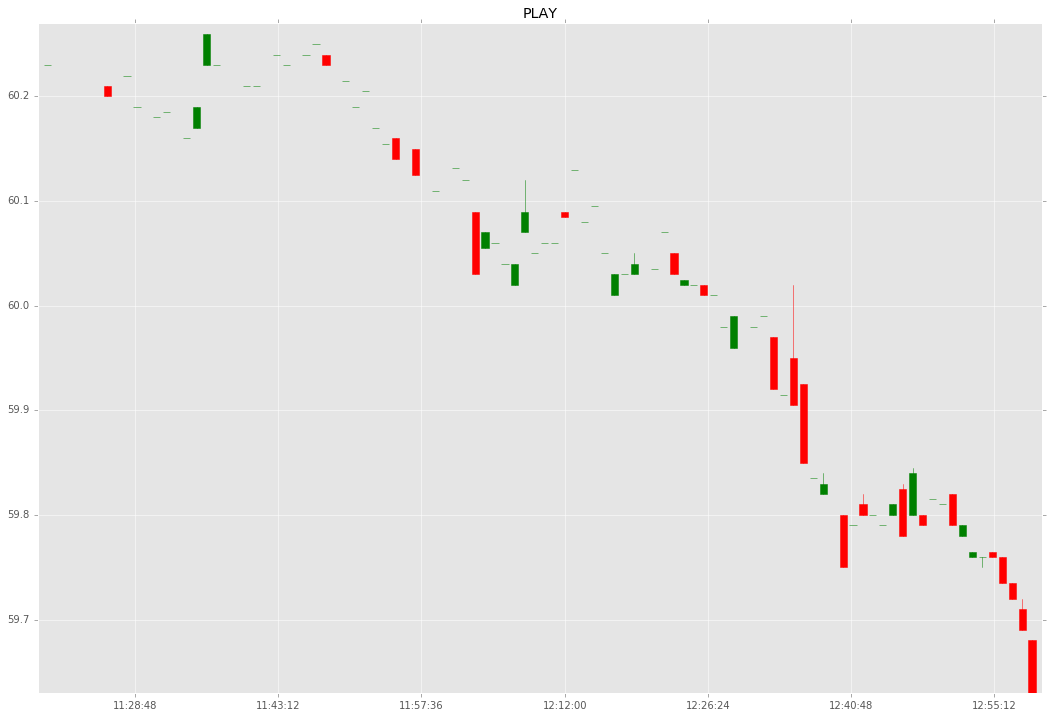

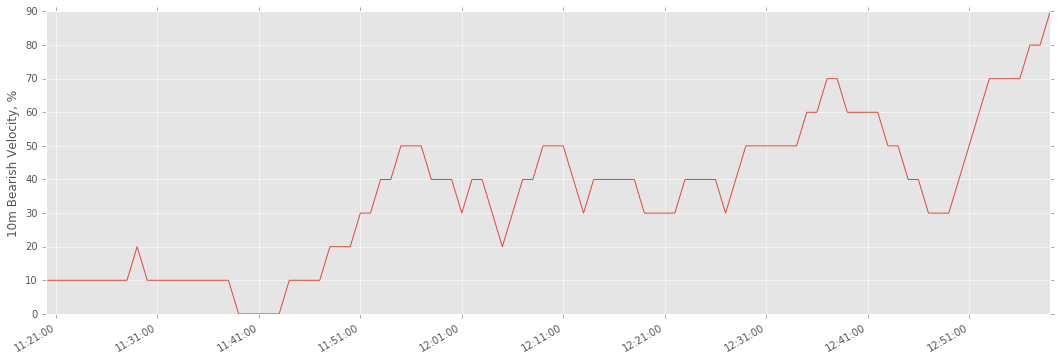

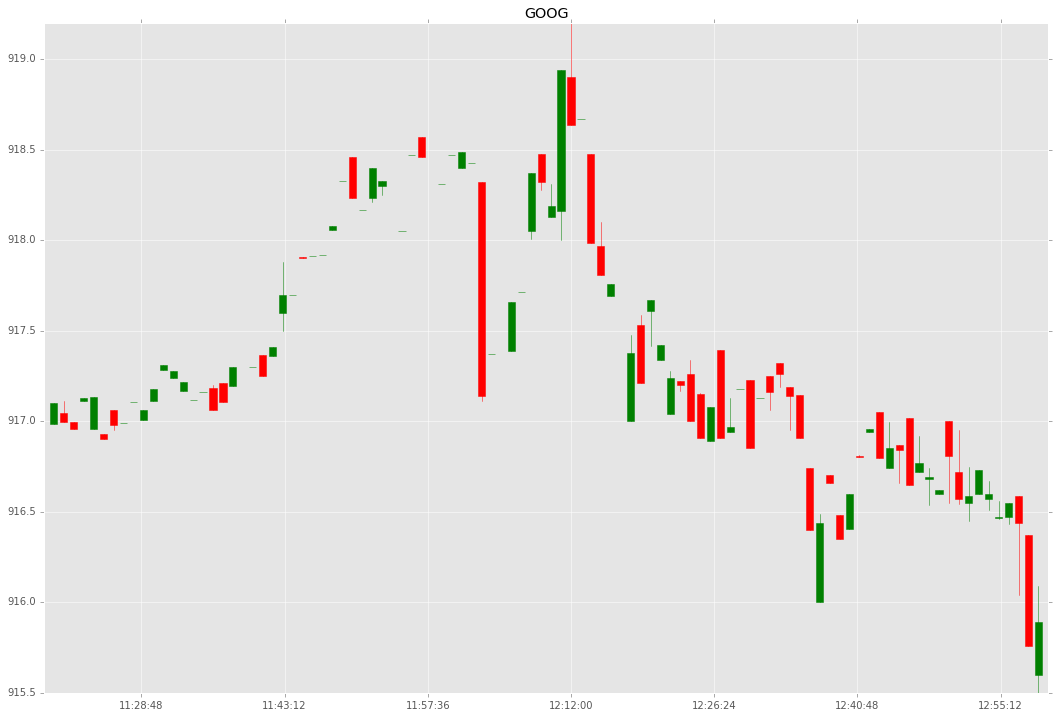

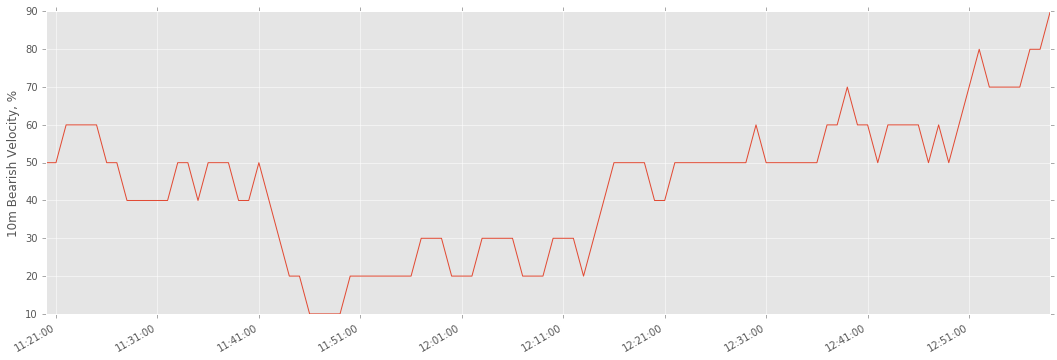

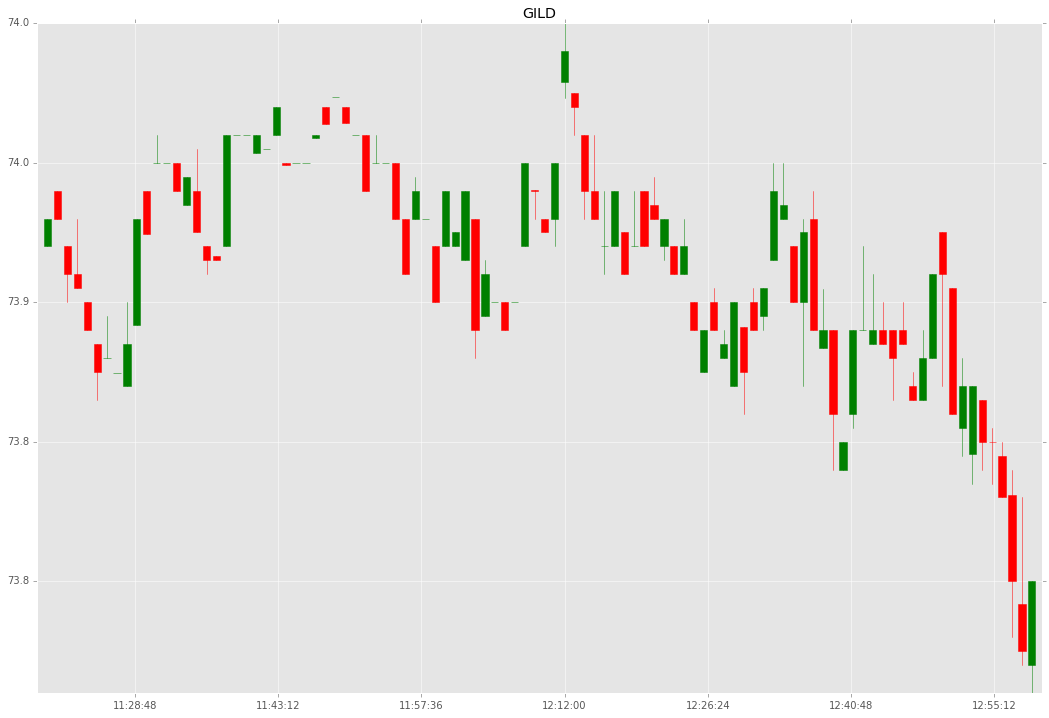

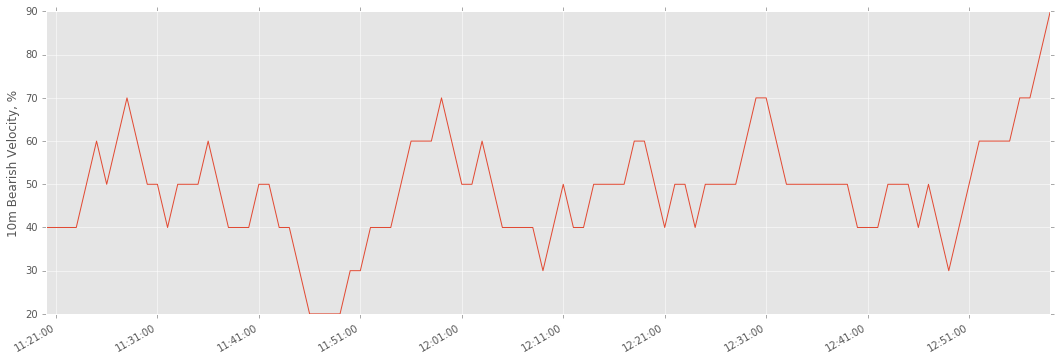

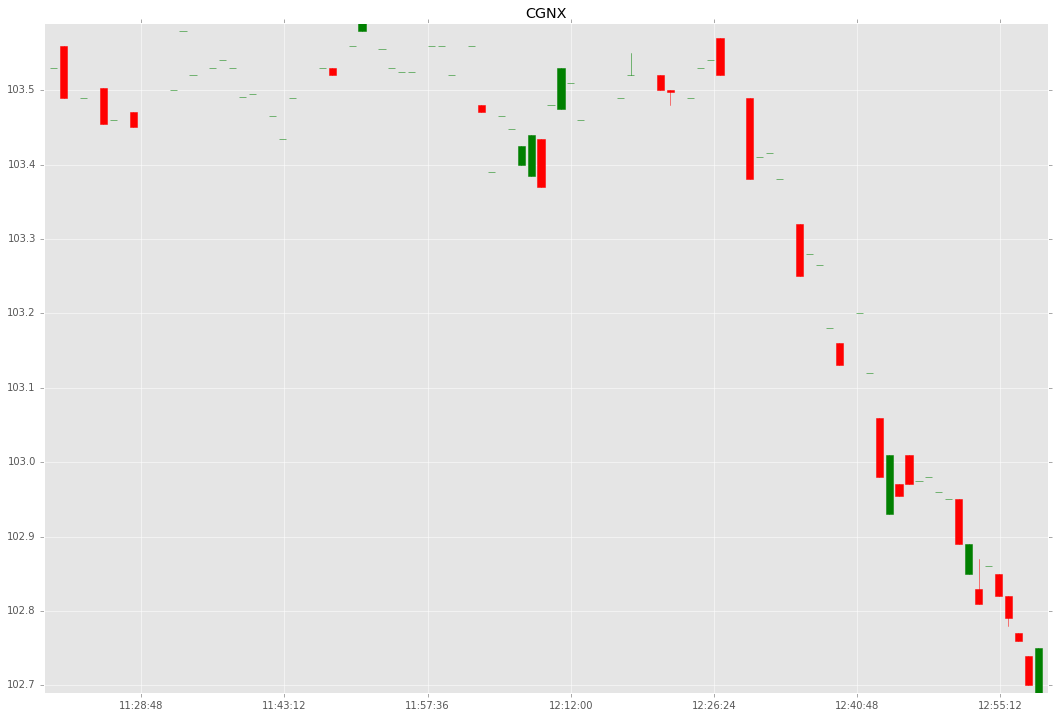

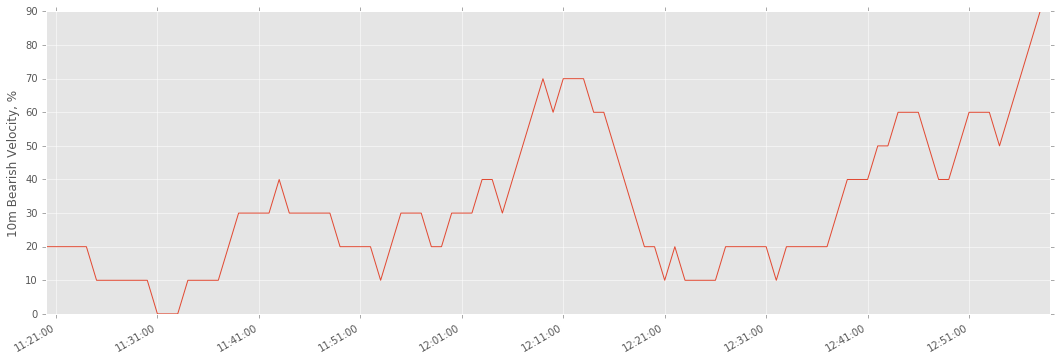

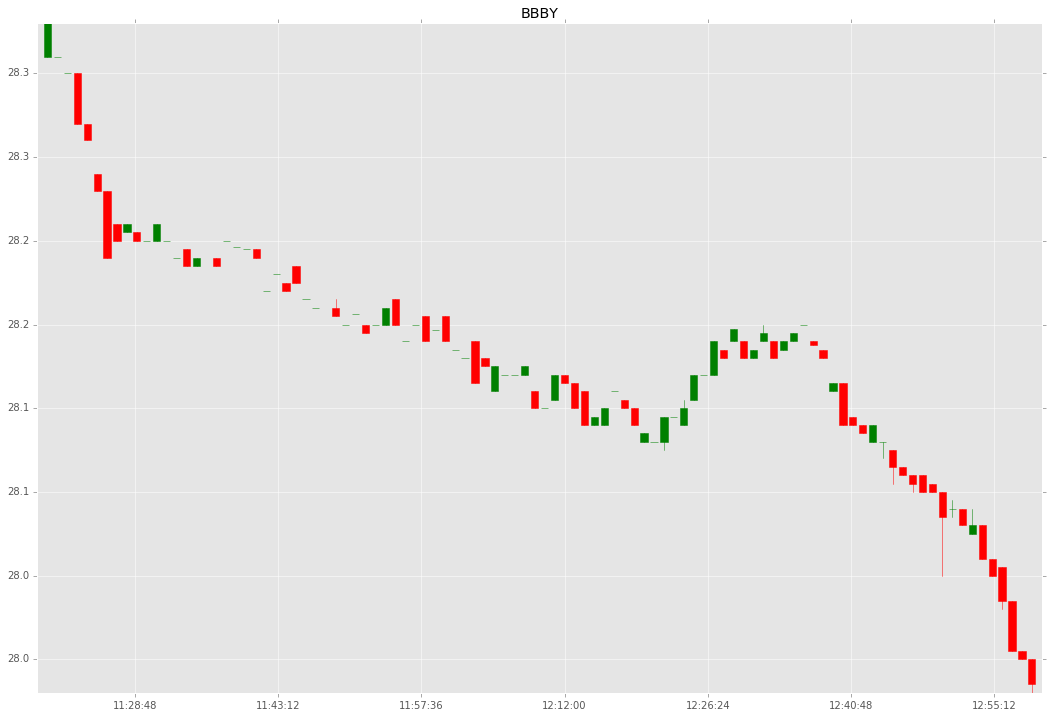

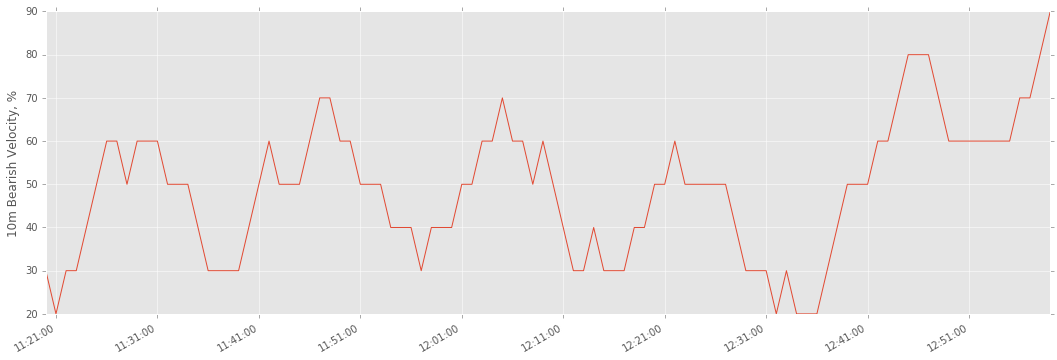

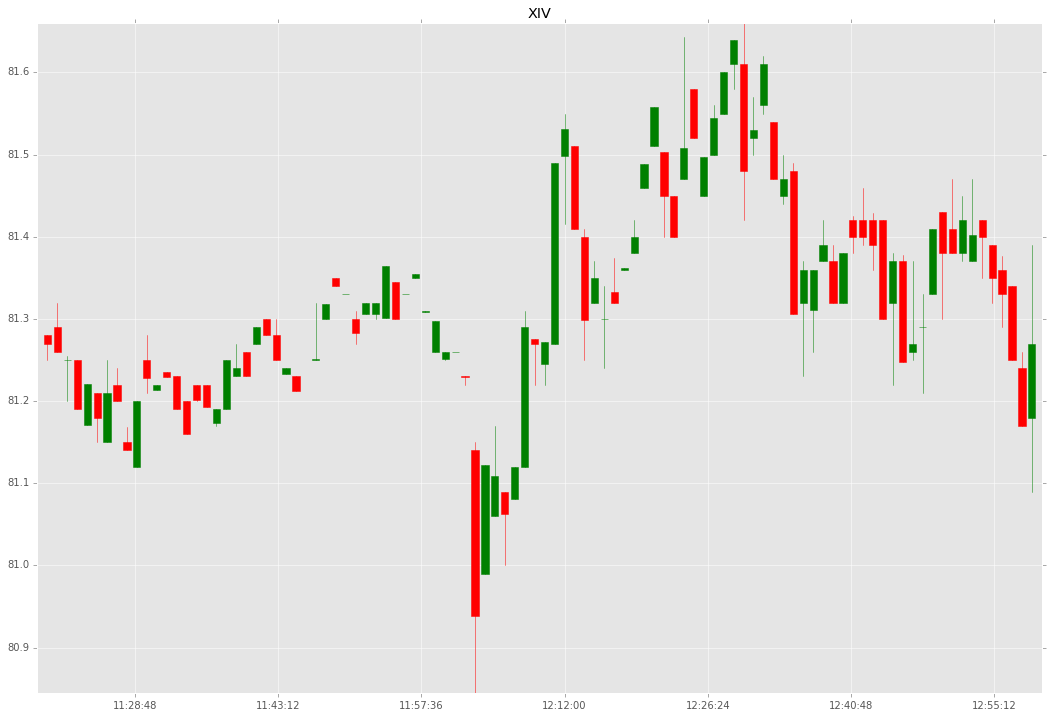

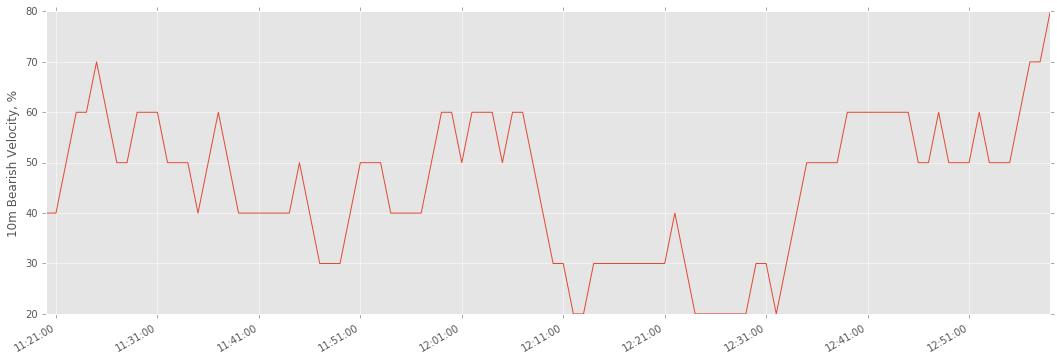

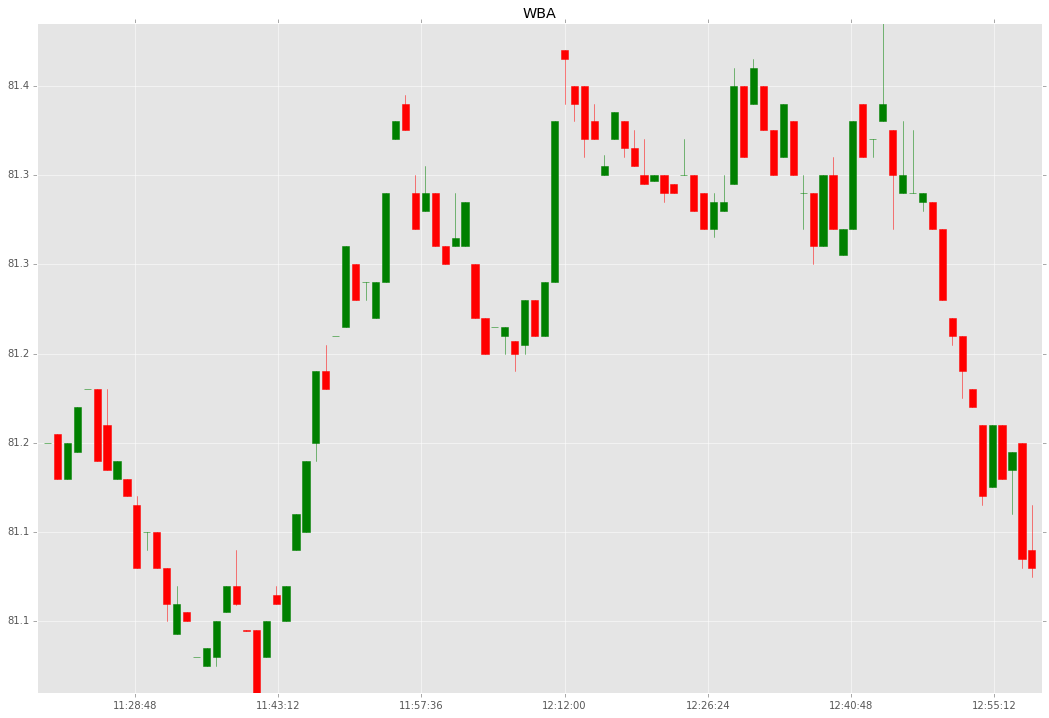

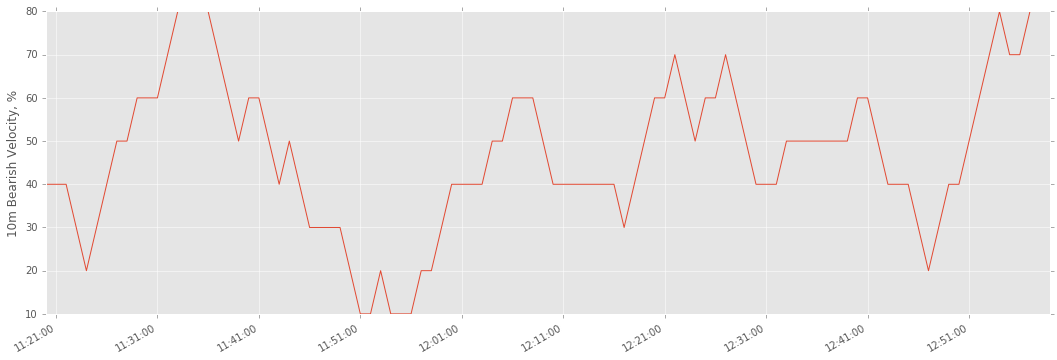

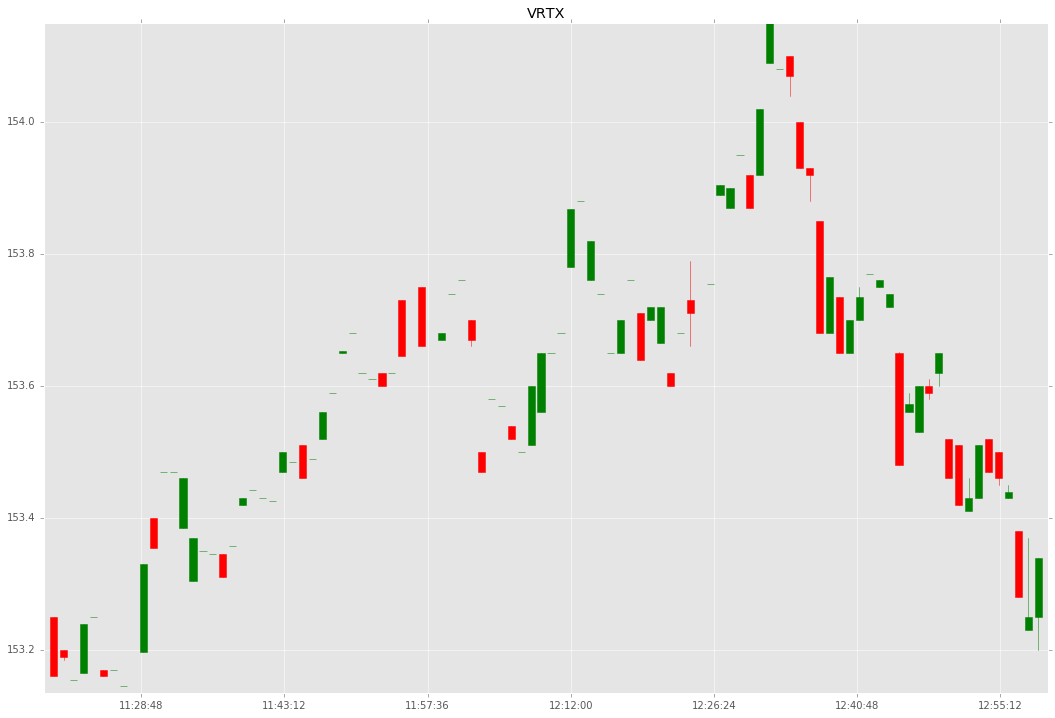

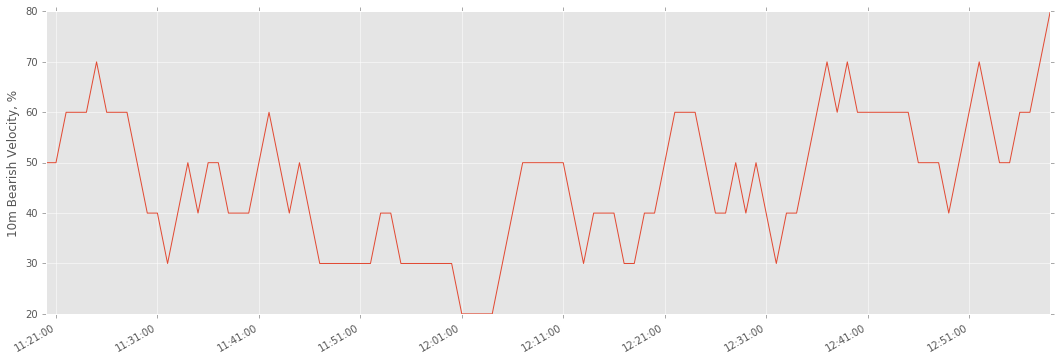

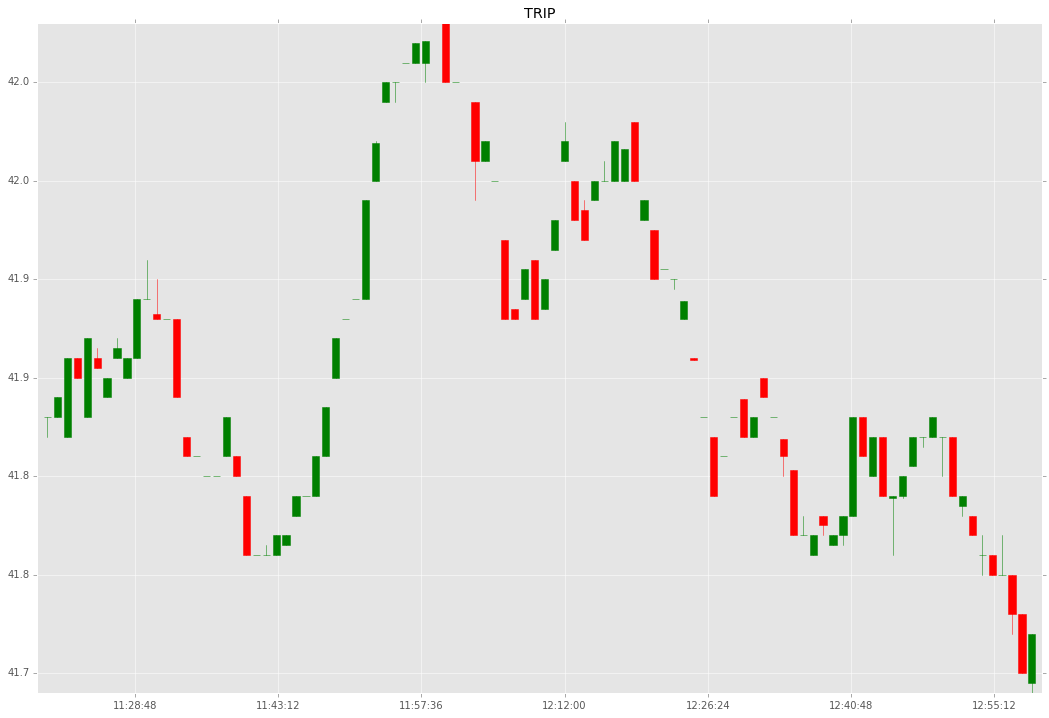

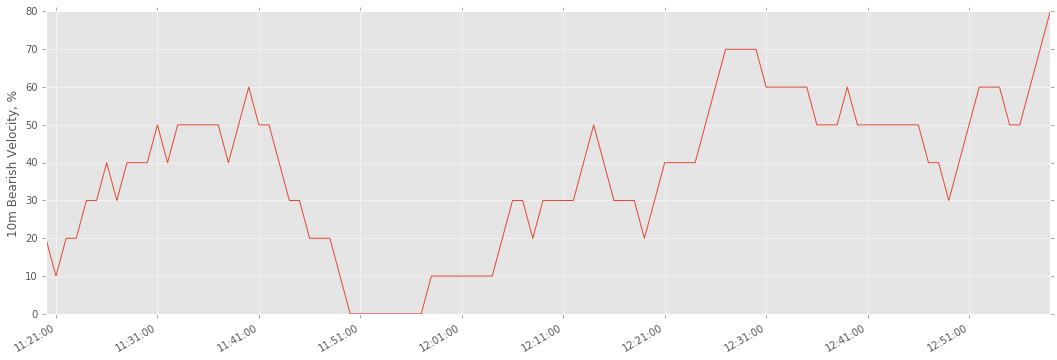

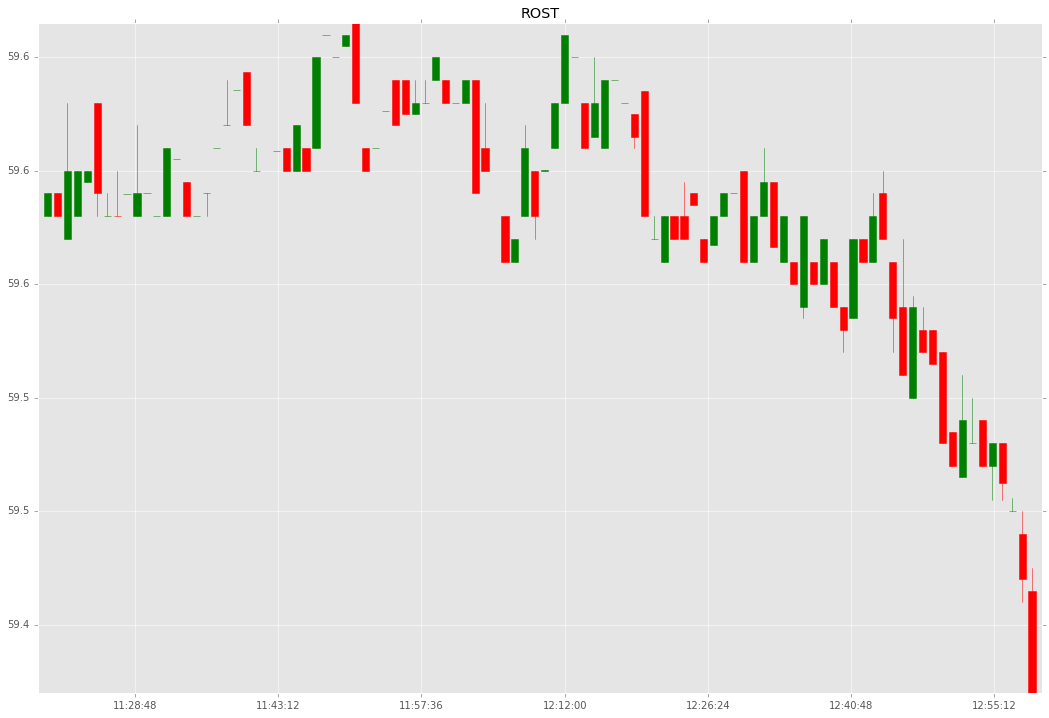

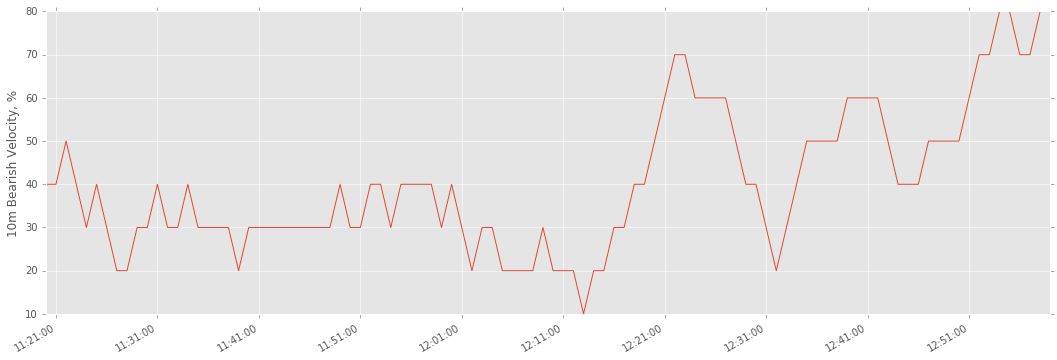

period 0:02:04.789773
QPACW {'chart': {'error': {'description': 'No data found, symbol may be delisted', 'code': 'Not Found'}, 'result': None}}
CPAAW {'chart': {'error': {'description': 'No data found, symbol may be delisted', 'code': 'Not Found'}, 'result': None}}
PLYAW {'chart': {'error': {'description': 'No data found, symbol may be delisted', 'code': 'Not Found'}, 'result': None}}


KeyboardInterrupt: 

In [11]:
prev_time = None
timeFormatter = DateFormatter('%H:%M:%S', tz=CLIENT_TIMEZONE)
now = get_now()
symbols = get_symbols()

while True:
    start = datetime.now()    
    if prev_time:
        seconds_since_update = (start - prev_time).seconds
        if seconds_since_update < 60:
            sleep(60 - seconds_since_update)    
    
    top_symbols_data = load_data(symbols, now) 
    clear_output()
    
    display(HTML("<h3>Top 10 V Bottom Candidates</h3>"))
    
    table = "<table width='100%'>"\
            "<tr><th>10m Bear Velocity</th><th>Min Low / Open</th><th>Symbol</th>"\
            "<th>Close / Min Low</th><th>10m Bull Velocity</th></tr>"
    for symbol, df in top_symbols_data: 
        latest_row = df.iloc[-1]
        
        table += "<tr><td>{}</td><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr>".format(
            latest_row["bear_velocity"],
            latest_row["min_low_open"],
            symbol,
            latest_row["close_min_low"],
            latest_row["bull_velocity"],
        )
        
        # plot data
        sub_df = df[-100:]  
        
        fig = plt.figure(figsize=(18, 12)) 
        ax1 = plt.subplot(111)
        ax1.set_title(symbol)
        candlestick_ochl(
            ax1, 
            ((date2num(r.Index), r.open, r.close, r.high, r.low) for r in sub_df.itertuples()), 
            width=.0005,
            colorup='g',  
            colordown='r',
        )
        ax1.xaxis.set_major_formatter(timeFormatter)
        ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,p: "%.1f" % x))
        x_min = date2num(sub_df.index.min() - timedelta(seconds=60))
        x_max = date2num(sub_df.index.max() + timedelta(seconds=60))
        ax1.set_xlim(x_min, x_max)
        ax1.set_ylim(sub_df.low.min(), sub_df.high.max())  
        
        fig = plt.figure(figsize=(18, 6)) 
        ax2 = plt.subplot(111)
        sub_df.bear_velocity.plot()
        ax2.xaxis.set_major_formatter(timeFormatter)
        ax2.set_ylabel('10m Bearish Velocity, %')
        
    
    table += "</table>"    
    display(HTML(table))
    
    display(HTML("<h3>Individual charts</h3>"))
    
    plt.show()    
    
    print("period", (datetime.now() - start))
    prev_time = start